In [9]:
from transformers import AutoTokenizer, AutoModel, utils
utils.logging.set_verbosity_error()  # Suppress standard warnings
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)

In [10]:
with open("prompt.txt", "r") as file:
        large_prompt = file.read()

inputs = tokenizer.encode("Prompt here", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 

In [ ]:
from bertviz import head_view
head_view(attention, tokens)

Top 20 tokens with highest attention:
{: 1.0000
,: 0.9685
width: 0.6826
[: 0.6228
tiles: 0.6130
{: 0.5560
:: 0.5521
': 0.5329
,: 0.5122
:: 0.5040
": 0.4836
": 0.4832
{: 0.4723
map: 0.4713
height: 0.4658
response: 0.4365
delivery: 0.4359
}: 0.4204
x: 0.4113
2: 0.4090

Bottom 20 tokens with lowest attention:
action: 0.0000
next: 0.0402
action: 0.0474
the: 0.0534
your: 0.0636
': 0.0769
just: 0.0774
ed: 0.0784
is: 0.0839
any: 0.0843
t: 0.0915
e: 0.0916
cel: 0.0960
,: 0.1040
8: 0.1059
a: 0.1085
par: 0.1100
8: 0.1105
]: 0.1111
what: 0.1118


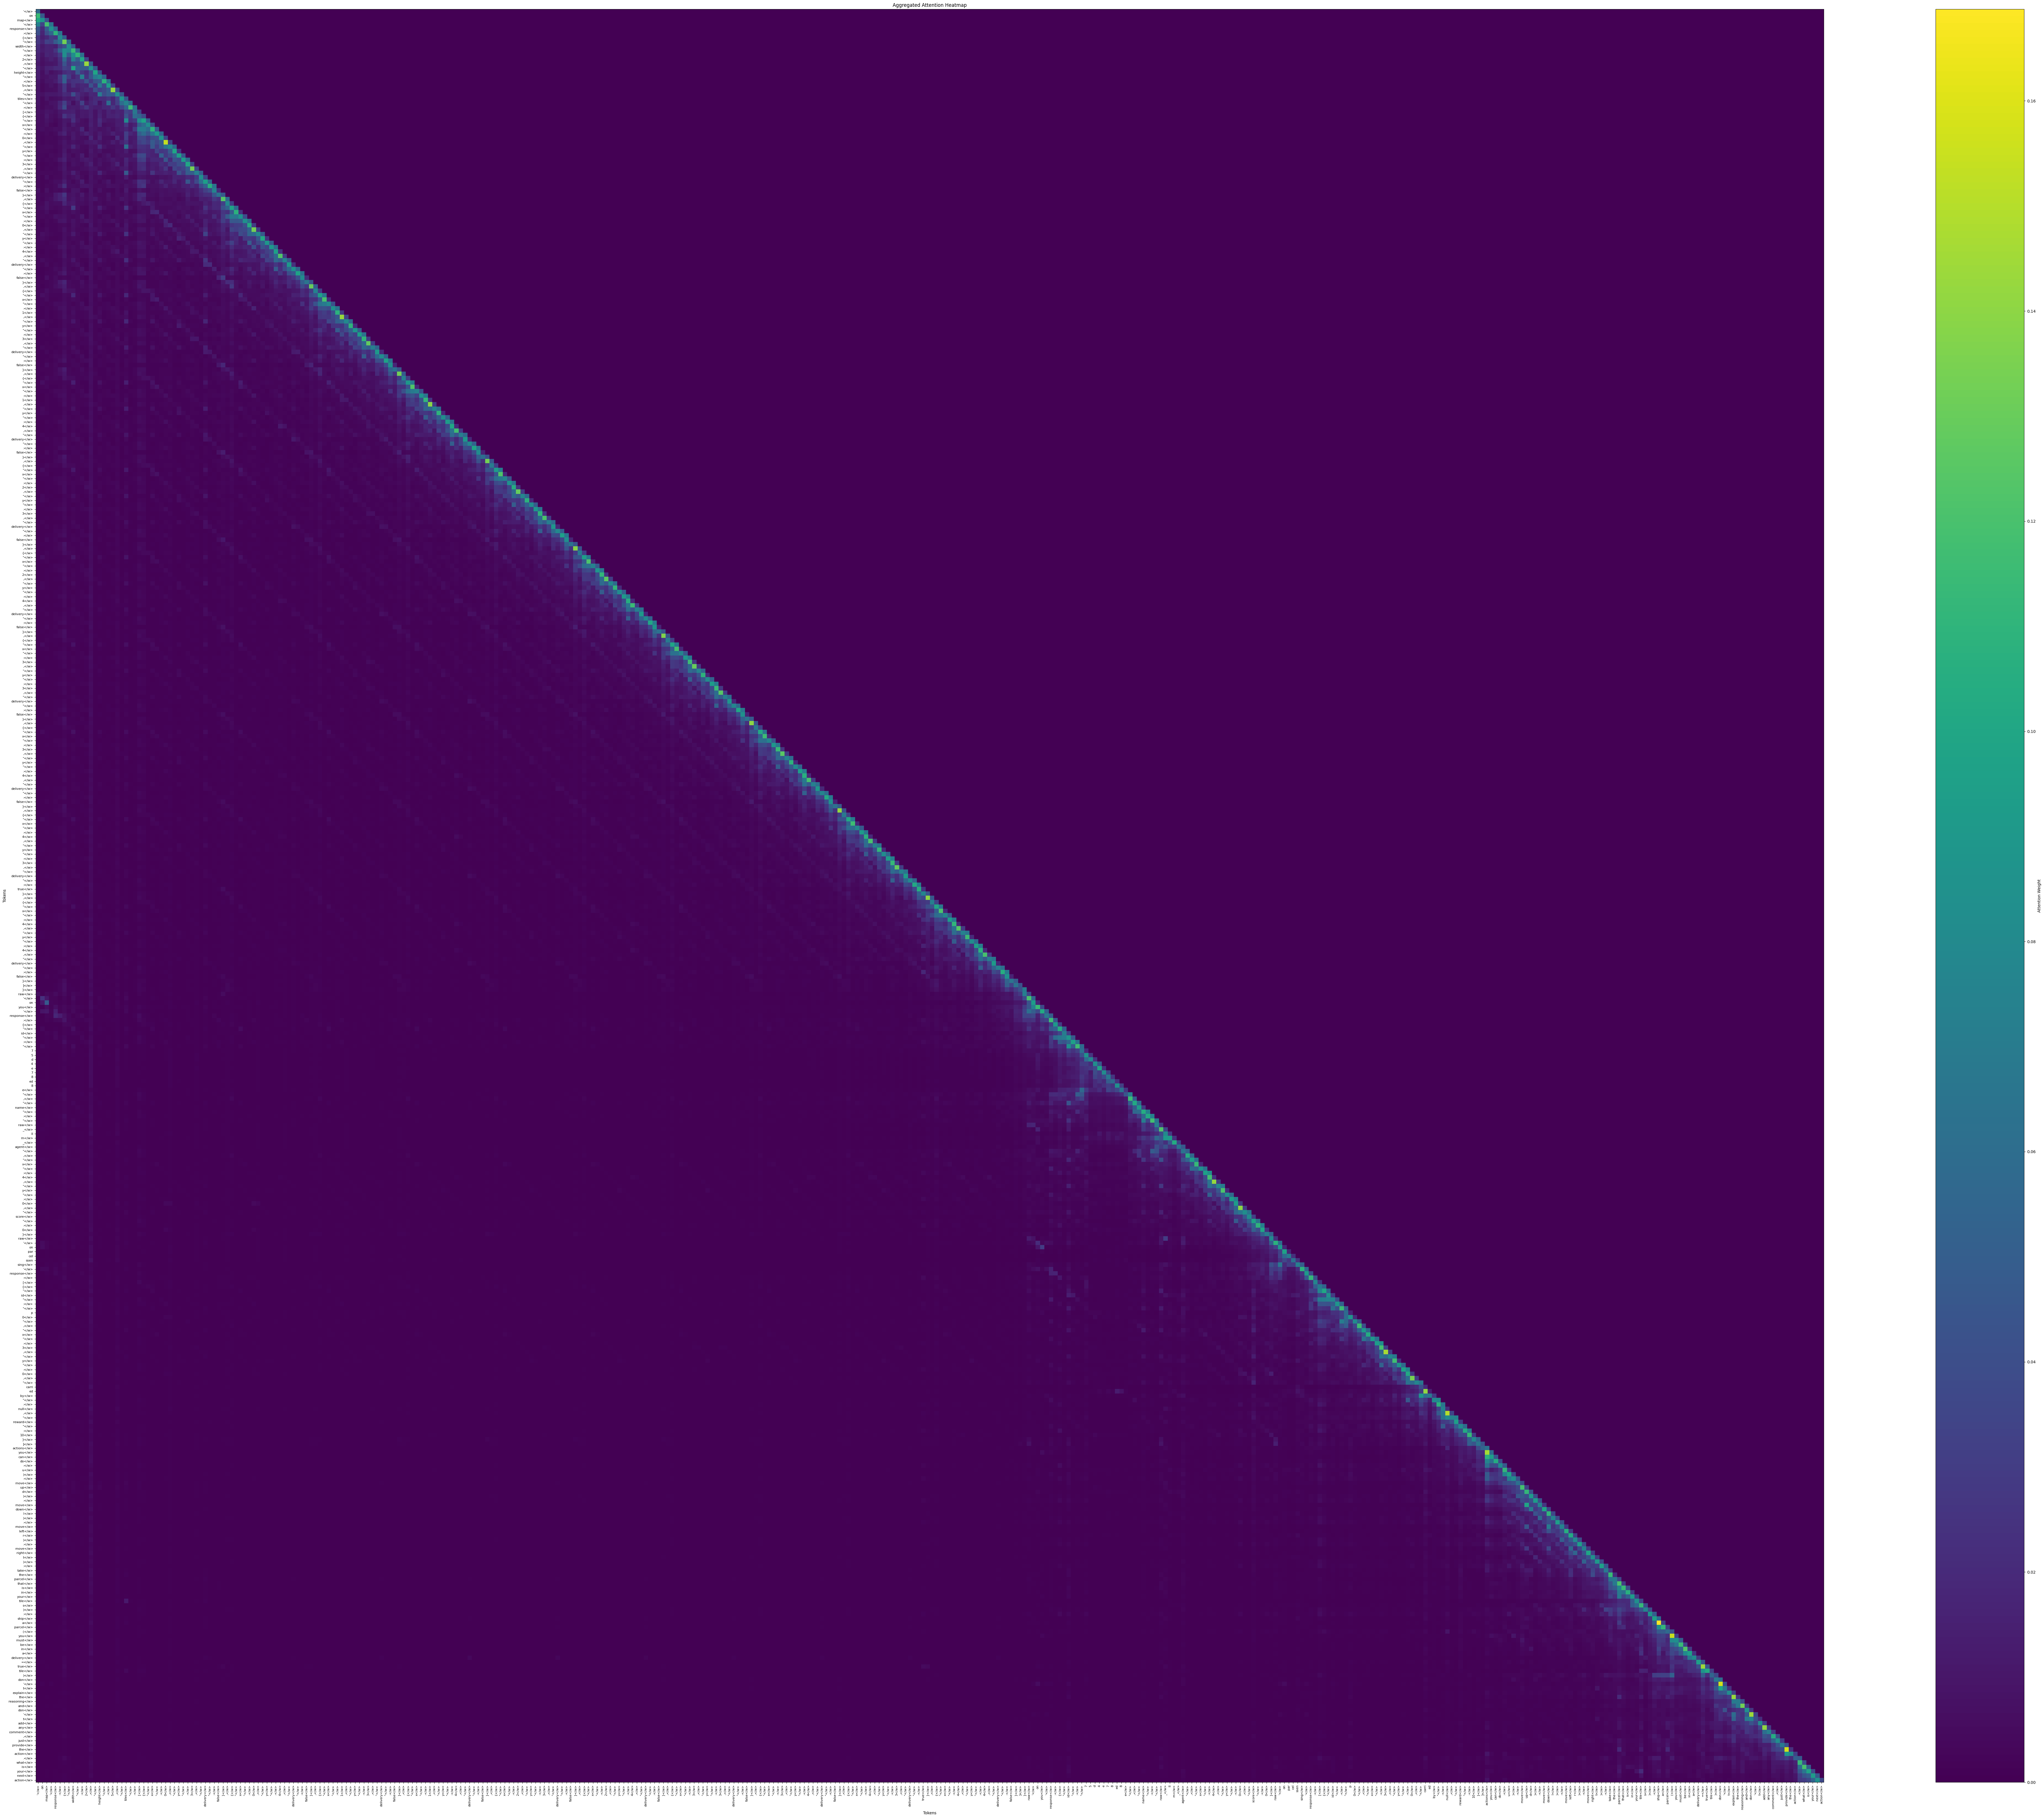

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(prompt, model_name="bert-base-uncased", top_x=20):
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, output_attentions=True)

    # Tokenize the input text
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)

    # Forward pass to get attention
    with torch.no_grad():
        outputs = model(**inputs)

    attentions = outputs.attentions  # List of attention tensors (layers, heads, seq_len, seq_len)

    # Aggregate attention across heads
    aggregated_attentions = [layer.mean(dim=1).squeeze(0).numpy() for layer in attentions]

    # Combine across all layers
    combined_attention = np.mean(aggregated_attentions, axis=0)

    # Token labels for visualization
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))

    # Remove first and last token (usually [CLS] and [SEP] for BERT)
    combined_attention = combined_attention[1:-1, 1:-1]
    tokens = tokens[1:-1]

    # Calculate average attention for each token
    avg_attention = combined_attention.mean(axis=0)

    # Normalize attention values to range [0, 1]
    min_val = avg_attention.min()
    max_val = avg_attention.max()
    normalized_attention = (avg_attention - min_val) / (max_val - min_val)

    # Get top X and bottom X tokens by attention
    top_indices = np.argsort(normalized_attention)[-top_x:][::-1]
    bottom_indices = np.argsort(normalized_attention)[:top_x]

    top_tokens = [(tokens[i], normalized_attention[i]) for i in top_indices]
    bottom_tokens = [(tokens[i], normalized_attention[i]) for i in bottom_indices]

    print(f"Top {top_x} tokens with highest attention:")
    for token, attention in top_tokens:
        print(f"{token.replace('</w>', '')}: {attention:.4f}")

    print(f"\nBottom {top_x} tokens with lowest attention:")
    for token, attention in bottom_tokens:
        print(f"{token.replace('</w>', '')}: {attention:.4f}")

    # Plot attention
    plt.figure(figsize=(80, 64))  # Increase the figure size for better navigation
    plt.imshow(combined_attention, cmap="viridis", aspect="auto")
    plt.colorbar(label="Attention Weight")
    plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=8)
    plt.yticks(range(len(tokens)), tokens, fontsize=8)
    plt.title("Aggregated Attention Heatmap")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.tight_layout()
    plt.show()

# Example usage
with open("prompt.txt", "r") as file:
        large_prompt = file.read()
visualize_attention(large_prompt, model_name="openai-gpt")
